In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn import tree
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense, Input

import ee

In [18]:
data = pd.read_csv('01_data.csv', index_col=0, parse_dates=True)
data.head()

,precip_in_inc,precip_in_cum,ndwi_watershed_green_nir,q_cfs_peak_BT_int,q_cfs_peak_SC_int,cy,month,wy,D0,D1,D2,D3,D4,wildfire_percent
2008-10-01,0.0,0.0,0.0000,12.2,1.43,2008,10,2009,100.0,100.0,0.0,0.0,0.0,0.0
2008-10-02,0.0,0.0,0.0000,11.6,2.01,2008,10,2009,100.0,100.0,0.0,0.0,0.0,0.0
2008-10-03,0.0,0.0,-0.3965,11.9,1.61,2008,10,2009,100.0,100.0,0.0,0.0,0.0,0.0
2008-10-04,0.0,0.0,-0.3965,35.6,23.80,2008,10,2009,100.0,100.0,0.0,0.0,0.0,0.0
2008-10-05,0.0,0.0,-0.3965,18.2,24.40,2008,10,2009,100.0,100.0,0.0,0.0,0.0,0.0


## Random Forest Model
Build Random forest model with several variables lagged, to get general idea of feature importance and model fit capabilities as a baseline. 

In [20]:
data_rfr = data.copy()
months_to_lag = [1, 2, 3, 4] 
drought_index_ints = [0, 1, 2, 3, 4]

for m in months_to_lag:
    data_rfr['lag_precip_' + str(m) + 'months'] = data_rfr['precip_in_inc'].shift(-30*m) # shift data back, 30 days in a month
    for d in drought_index_ints:
        data_rfr['lag_d' + str(d) + '_' + str(m) + 'months'] = data_rfr['D' + str(d)].shift(-30*m) #shift back data

hours_to_lag = [1, 2, 5, 14, 30]
for h in hours_to_lag:
    data_rfr['lag_precip_' + str(h) + 'days'] = data_rfr['precip_in_inc'].shift(h) # shift data back h hours


data_rfr.dropna(inplace=True) #drop null values created with shift functions - will be most recent 4 months
data_rfr.head()


,precip_in_inc,precip_in_cum,ndwi_watershed_green_nir,q_cfs_peak_BT_int,q_cfs_peak_SC_int,cy,month,wy,D0,D1,...,lag_d0_4months,lag_d1_4months,lag_d2_4months,lag_d3_4months,lag_d4_4months,lag_precip_1days,lag_precip_2days,lag_precip_5days,lag_precip_14days,lag_precip_30days
2008-10-31,0.0,0.0,-0.6433,36.2,22.0,2008,10,2009,100.0,100.00,...,100.0,100.0,13.47,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-11-01,0.0,0.0,-0.6433,529.0,519.0,2008,11,2009,100.0,100.00,...,100.0,100.0,13.47,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-11-02,0.0,0.0,-0.6433,446.0,556.0,2008,11,2009,100.0,100.00,...,100.0,100.0,13.47,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-11-03,0.0,0.0,-0.6433,223.0,223.0,2008,11,2009,100.0,100.00,...,100.0,100.0,13.47,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-11-04,0.0,0.0,-0.6932,153.0,188.0,2008,11,2009,100.0,15.43,...,100.0,100.0,13.47,0.0,0.0,0.0,0.0,0.0,0.0,0.0


training model score:  0.8649898472326736
test model score:  0.6213650756976732


<Axes: >

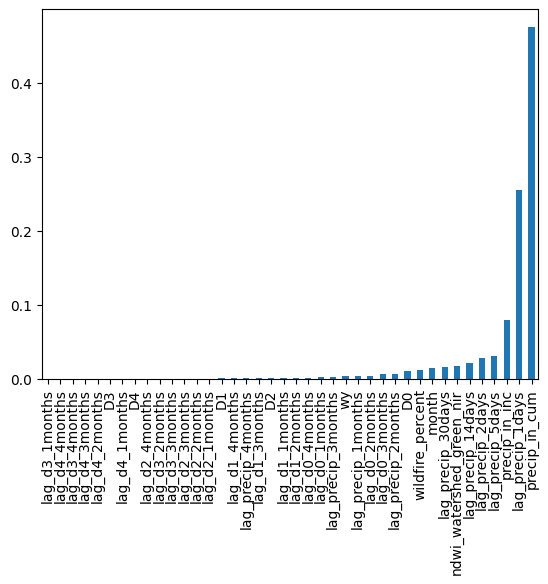

In [21]:
X = data_rfr.drop(['q_cfs_peak_SC_int', 'q_cfs_peak_BT_int', 'cy'], axis=1)
y = data_rfr['q_cfs_peak_SC_int']
X_train_SC, X_test_SC, y_train_SC, y_test_SC = train_test_split(X, y, test_size=0.2, random_state=777)

rfr = RandomForestRegressor(max_depth=5, n_estimators=100, random_state=777)
rfr.fit(X_train_SC, y_train_SC)
y_pred_SC = rfr.predict(X_test_SC)

print('training model score: ', rfr.score(X_train_SC, y_train_SC))
print('test model score: ', rfr.score(X_test_SC, y_test_SC))

#next, we'll take a look at feature importance
importances = rfr.feature_importances_
forest_importances = pd.Series(importances, index=X_train_SC.columns)

fig, ax = plt.subplots()
forest_importances.sort_values().plot.bar(ax=ax)


training model score:  0.8768897724351157
test model score:  0.6123491543440336


<Axes: >

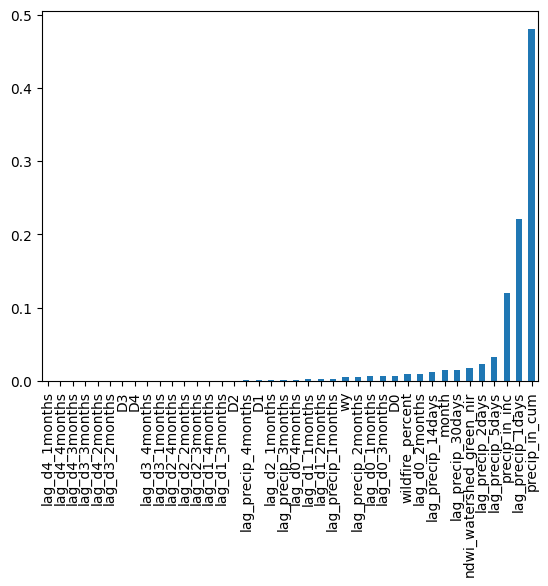

In [22]:
X = data_rfr.drop(['q_cfs_peak_SC_int', 'q_cfs_peak_BT_int', 'cy'], axis=1)
y = data_rfr['q_cfs_peak_BT_int']
X_train_BT, X_test_BT, y_train_BT, y_test_BT = train_test_split(X, y, test_size=0.2, random_state=777)

rfr = RandomForestRegressor(max_depth=5, n_estimators=100, random_state=777)
rfr.fit(X_train_BT, y_train_BT)
y_pred_BT = rfr.predict(X_test_BT)
print('training model score: ', rfr.score(X_train_BT, y_train_BT))
print('test model score: ', rfr.score(X_test_BT, y_test_BT))

#next, we'll take a look at feature importance
importances = rfr.feature_importances_
forest_importances = pd.Series(importances, index=X_train_BT.columns)

fig, ax = plt.subplots()
forest_importances.sort_values().plot.bar(ax=ax)


Text(0, 0.5, 'observed streamflow')

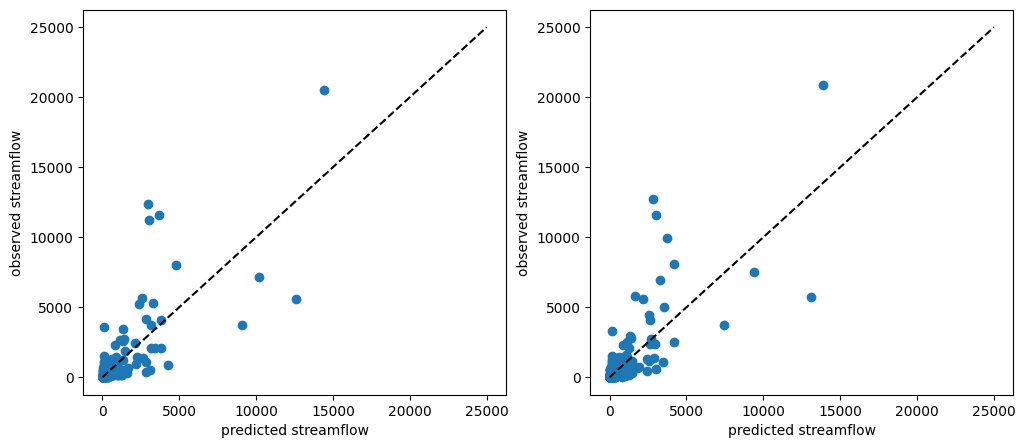

In [23]:
## plot results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(y_pred_BT, y_test_BT)
ax1.plot((0, 25000), (0, 25000), 'k', linestyle='--')
ax1.set_xlabel('predicted streamflow')
ax1.set_ylabel('observed streamflow')


ax2.scatter(y_pred_SC, y_test_SC)
ax2.plot((0, 25000), (0, 25000), 'k', linestyle='--')
ax2.set_xlabel('predicted streamflow')
ax2.set_ylabel('observed streamflow')

## RFR Results
Most importance features are: 
- precip and lag of precip is obviously most important model feature.

Model underpredicts flow peaks (typical of RFR)

RFR model appears to explain 85% of model variability (R_squared), but overfits in the train period (r_squared for test is 0.65)
Could possibly improve with different hyperparameters, but good first gut check model


## LSTM Model



In [110]:
target = 'q_cfs_peak_BT_int'

In [111]:
data_lstm = data.copy()

#have 15 years of data, split to train/test on 10/5 years. last 5 years include one wet, one dry, and 3 middlish years, so good variety to test on
data_lstm_test = data_lstm.loc[data_lstm.wy >= 2019, :] 
data_lstm_train = data_lstm.loc[data_lstm.wy < 2019, :]

X_train = data_lstm_train.drop(['q_cfs_peak_SC_int', 'q_cfs_peak_BT_int', 'cy', 'wy', 'month'], axis=1)
X_test = data_lstm_test.drop(['q_cfs_peak_SC_int', 'q_cfs_peak_BT_int', 'cy', 'wy', 'month'], axis=1)
## scale x data
scaler = MinMaxScaler().set_output(transform="pandas")
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = data_lstm_train[target]
y_test = data_lstm_test[target]

scaler = MinMaxScaler().set_output(transform="pandas")
y_train = np.log(y_train)
y_test = np.log(y_test)





In [112]:
#separate sequences from x and y data. 

def split_sequence(sequence, n_steps, target):
    X_out, y_out = list(), list() # initialize output

    for n in range(len(sequence) - n_steps + 1): #step through data, skipping last n_steps rows so all sequences are same size
        this_batch = sequence.iloc[n:n+n_steps, :]
        X_out.append(this_batch.drop([target], axis=1))
        y_out.append(this_batch[target])

    return np.array(X_out), np.array(y_out)

In [113]:
#recombine X, y after scaling to make sure sequences are calculated correctly
xy_train = pd.concat([X_train, y_train], axis=1)
xy_test = pd.concat([X_test, y_test], axis=1)
n_steps = 240
X_train_seq, y_train_seq = split_sequence(xy_train, n_steps, target)
X_test_seq, y_test_seq = split_sequence(xy_test, n_steps, target)

In [114]:
model = Sequential()
# col_num = np.array(X_train).shape[2]
# input_shape = (batch_size, time_steps, number_of_features)
#number_of_features = # of cols
# timesteps = window size 
# batch_size how many samples are input once reshaped
model.add(Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2]))) #input shape
model.add(LSTM(100, return_sequences=True, go_backwards=True))
model.add(LSTM(100, return_sequences=True, go_backwards=False))
model.add(LSTM(50))
model.add(Dense(1)) #output layer
model.compile(optimizer='adam', loss='mean_squared_logarithmic_error')
model.fit(X_train_seq, y_train_seq, epochs=10)

Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 23s 201ms/step - loss: 0.3751
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 21s 198ms/step - loss: 0.0528
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 22s 202ms/step - loss: 0.0531
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 22s 202ms/step - loss: 0.0566
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 22s 208ms/step - loss: 0.0547
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 21s 200ms/step - loss: 0.0548
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 21s 200ms/step - loss: 0.0563
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 21s 200ms/step - loss: 0.0540
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 21s 200ms/step - loss: 0.0533
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 21s 200ms/step - loss: 0.0513


In [115]:
y_pred = model.predict(X_test_seq)

58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step


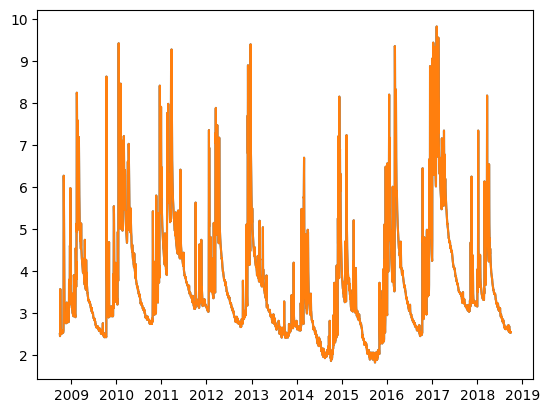

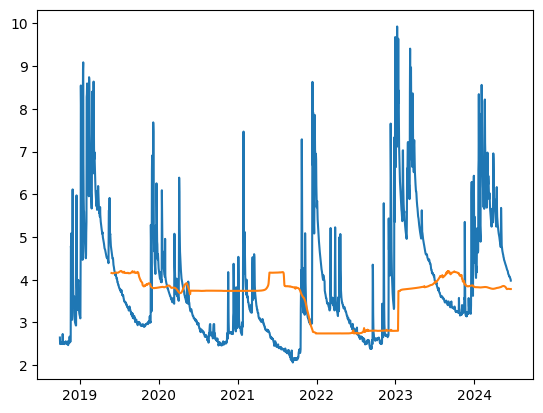

In [116]:
f, ax = plt.subplots(1, 1)
ax.plot(y_train)
ax.plot(xy_train.index, y_train)

f, ax = plt.subplots(1, 1)
ax.plot(y_test)
ax.plot(xy_test.index[n_steps-1::], y_pred)

## Daily Model

In [104]:
data_lstm = data.resample('1d').median()

#have 15 years of data, split to train/test on 10/5 years. last 5 years include one wet, one dry, and 3 middlish years, so good variety to test on
data_lstm_test = data_lstm.loc[data_lstm.wy >= 2019, :] 
data_lstm_train = data_lstm.loc[data_lstm.wy < 2019, :]

X_train = data_lstm_train.drop(['q_cfs_peak_SC_int', 'q_cfs_peak_BT_int', 'cy', 'wy', 'month'], axis=1)
X_test = data_lstm_test.drop(['q_cfs_peak_SC_int', 'q_cfs_peak_BT_int', 'cy', 'wy', 'month'], axis=1)
## scale x data
scaler = MinMaxScaler().set_output(transform="pandas")
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = data_lstm_train['q_cfs_peak_SC_int']
y_test = data_lstm_test['q_cfs_peak_SC_int']

scaler = MinMaxScaler().set_output(transform="pandas")
y_train = np.log(y_train)
y_test = np.log(y_test)

In [105]:
#recombine X, y after scaling to make sure sequences are calculated correctly
xy_train = pd.concat([X_train, y_train], axis=1)
xy_test = pd.concat([X_test, y_test], axis=1)
n_steps = 240
X_train_seq, y_train_seq = split_sequence(xy_train, n_steps, 'q_cfs_peak_SC_int')
X_test_seq, y_test_seq = split_sequence(xy_test, n_steps, 'q_cfs_peak_SC_int')

In [106]:
model = Sequential()
# col_num = np.array(X_train).shape[2]
# input_shape = (batch_size, time_steps, number_of_features)
#number_of_features = # of cols
# timesteps = window size 
# batch_size how many samples are input once reshaped
model.add(Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2]))) #input shape
model.add(LSTM(100, return_sequences=True, go_backwards=True))
model.add(LSTM(100, return_sequences=True, go_backwards=False))
model.add(LSTM(50))
model.add(Dense(1)) #output layer
model.compile(optimizer='adam', loss='mean_squared_logarithmic_error')
model.fit(X_train_seq, y_train_seq, epochs=10)

Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 23s 201ms/step - loss: 0.4729
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 21s 201ms/step - loss: 0.1178
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 22s 203ms/step - loss: 0.1088
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 23s 212ms/step - loss: 0.1084
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 22s 205ms/step - loss: 0.1073
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 22s 202ms/step - loss: 0.1083
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 22s 206ms/step - loss: 0.1061
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 22s 204ms/step - loss: 0.1012
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 22s 203ms/step - loss: 0.1088
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 22s 203ms/step - loss: 0.1029


In [107]:
y_pred = model.predict(X_test_seq)

58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step


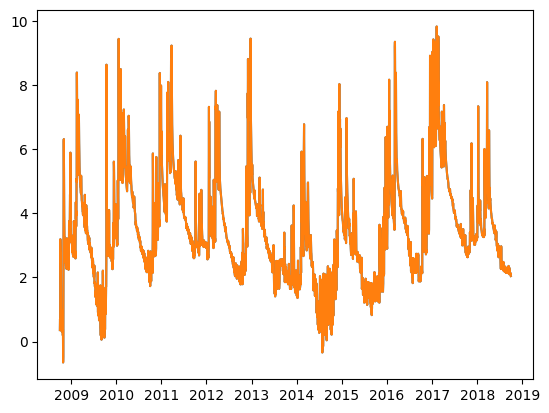

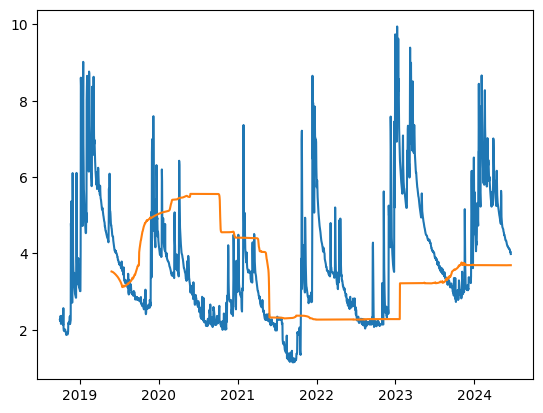

In [108]:
f, ax = plt.subplots(1, 1)
ax.plot(y_train)
ax.plot(xy_train.index, y_train)

f, ax = plt.subplots(1, 1)
ax.plot(y_test)
ax.plot(xy_test.index[n_steps-1::], y_pred)

## Summary of work

## Next steps
- maybe switch model to daily?
- train model on longer period
- add in cumulative precip

#### LSTM Resources Used for this notebook

- https://github.com/MohammadFneish7/Keras_LSTM_Diagram
- https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
- https://gabenosek.medium.com/time-series-stock-prediction-with-lstm-eb04f2224c22
